In [3]:
!rm -rf /content/sample_data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install -q -U datasets transformers torch peft trl tqdm accelerate deepspeed evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 

In [1]:
#Load the datset
from pathlib import Path
from typing import Dict, Any, List,Union
from datasets import (load_dataset,
                      DatasetDict,
                      concatenate_datasets
                      )
def load_and_prepare_dataset(
    input_source: Union[str, Path, Dict[str, List[Union[str, Path]]]],
    split_ratios: tuple = (0.8, 0.1, 0.1),
    seed: int = 42,
    streaming: bool = False
) -> DatasetDict:
    """
    Load a dataset from various input sources and prepare it by splitting into train, test, and eval sets.

    :param input_source: A dataset name, path to a folder, a single file, multiple files, or a dictionary specifying train, test, and eval files.
    :param split_ratios: A tuple containing the ratios for train, test, and eval splits (default is (0.8, 0.1, 0.1)).
    :param seed: A random seed for reproducibility of the split (default is 42).
    :param streaming: Whether to use streaming to handle large files (default is False).
    :return: A DatasetDict containing the split datasets.

    Example:
    # Example usage with streaming for large files:
    # dataset_dict = load_and_prepare_dataset({
    #     'train': ['train_file_1.csv', 'train_file_2.csv'],
    #     'test': ['test_file.csv'],
    #     'eval': ['eval_file.csv']
    # }, streaming=True)
    # print(dataset_dict)
    OUTPUT1:
    DatasetDict({
    train: DatasetDict({
        train: Dataset({
            features: ['act', 'prompt'],
            num_rows: 459
        })
    })
    test: DatasetDict({
        train: Dataset({
            features: ['act', 'prompt'],
            num_rows: 459
        })
    })
    eval: DatasetDict({
        train: Dataset({
            features: ['act', 'prompt'],
            num_rows: 153
        })
    })
    })
    EXAMPLE2:
    dataset=load_and_prepare_dataset('fka/awesome-chatgpt-prompts')
    DatasetDict({
    train: Dataset({
        features: ['act', 'prompt'],
        num_rows: 122
    })
    test: Dataset({
        features: ['act', 'prompt'],
        num_rows: 15
    })
    eval: Dataset({
        features: ['act', 'prompt'],
        num_rows: 16
    })
    })
    EXAMPLE3:
    datset_path=load_and_prepare_dataset('/content/awesome-chatgpt-prompts')
DatasetDict({
    train: Dataset({
        features: ['act', 'prompt'],
        num_rows: 122
    })
    test: Dataset({
        features: ['act', 'prompt'],
        num_rows: 15
    })
    eval: Dataset({
        features: ['act', 'prompt'],
        num_rows: 16
    })
    })

    """
    # Load dataset from different types of input sources
    if isinstance(input_source, (str, Path)):
        # Dataset name, single file or path to folder
        dataset = load_dataset(input_source, streaming=streaming)
        dataset = DatasetDict(dataset)
    elif isinstance(input_source, dict):
        # Dictionary with specified train, test, and eval files
        formats = ['csv', 'json', 'jsonl', 'parquet', 'txt']
        datasets = {}
        for split, files in input_source.items():
            format_detected = None
            for fmt in formats:
                if any(str(file).endswith(fmt) for file in files):
                    format_detected = fmt
                    break
            if format_detected is None:
                raise ValueError(f"No supported file format detected for files: {files}")
            datasets[split] = load_dataset(format_detected, data_files=files, streaming=streaming)
        dataset = DatasetDict(datasets)
    else:
        raise ValueError("Input source should be a dataset name, path to a folder, a single file, multiple files, or a dictionary.")

    # Perform the split if needed and if not in streaming mode
    if not streaming:
        train_size, test_size, eval_size = split_ratios
        assert 0.0 < train_size < 1.0 and 0.0 < test_size < 1.0 and 0.0 < eval_size < 1.0 and (train_size + test_size + eval_size) == 1.0, \
            "Split ratios must be between 0 and 1 and sum up to 1."

        if "train" not in dataset or "test" not in dataset or "eval" not in dataset:
            # Assuming all splits are to be derived from the 'train' dataset
            full_dataset = concatenate_datasets(list(dataset.values())) if isinstance(dataset, dict) else dataset
            split_dataset = full_dataset.train_test_split(train_size=train_size, seed=seed)
            test_eval_split = split_dataset['test'].train_test_split(test_size=test_size / (test_size + eval_size), seed=seed)

            dataset = DatasetDict({
                "train": split_dataset["train"],
                "test": test_eval_split["train"],
                "eval": test_eval_split["test"]
            })

    return dataset


transformers
accelerate
evaluate
deepspeed
tqdm
datasets

In [28]:
!git clone https://huggingface.co/andupets/real-estate-image-classification.git

Cloning into 'real-estate-image-classification'...
remote: Enumerating objects: 20, done.
remote: Total 20 (delta 0), reused 0 (delta 0), pack-reused 20
Unpacking objects: 100% (20/20), 3.37 KiB | 344.00 KiB/s, done.
Filtering content: 100% (9/9), 327.60 MiB | 13.42 MiB/s, done.


In [29]:
from datasets import load_dataset

dataset = load_and_prepare_dataset("/content/real-estate-image-classification",)
dataset

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 5
    })
    test: Dataset({
        features: ['image'],
        num_rows: 1
    })
    eval: Dataset({
        features: ['image'],
        num_rows: 1
    })
})

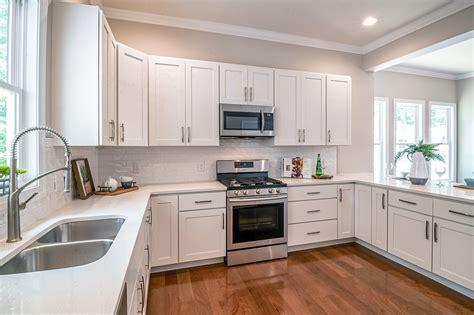

In [30]:
dataset['train']['image'][1]

In [ ]:
label2id, id2label

In [32]:
from transformers import AutoImageProcessor
model_checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [35]:
from transformers import AutoImageProcessor, ViTFeatureExtractor
from PIL import Image

# Function to preprocess an image using the provided AutoImageProcessor
def preprocess_image(image_path: str, image_processor: ViTFeatureExtractor) -> dict:
    """
    Preprocess the image using the given image processor.

    Parameters:
    - image_path (str): The file path to the image to be processed.
    - image_processor (ViTFeatureExtractor): An instance of ViTFeatureExtractor from the transformers library.

    Returns:
    - dict: A dictionary containing the preprocessed image tensor and additional processing information.
    """
    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Apply the preprocessing (resizing, normalization, etc.)
    processed_image = image_processor(images=image, return_tensors="pt")

    return processed_image

# Use the defined function to preprocess an image
model_checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)

# Example image path
image_path = "/content/real-estate-image-classification/images/bathroom.jpg"

# Preprocess the image
preprocessed_image = preprocess_image(image_path=image_path, image_processor=image_processor)

# The `preprocessed_image` is now ready to be passed to the model for inference.

In [36]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [ ]:
labels = dataset['train'].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]

In [37]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
print_trainable_parameters(model)

trainable params: 85798656 || all params: 85798656 || trainable%: 100.00


In [38]:
output=model(**preprocessed_image)

In [ ]:
output.logits

In [25]:
import torch


def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

TypeError: 'JpegImageFile' object is not iterable

In [34]:
preprocessed_image

{'pixel_values': tensor([[[[0.5686, 0.5843, 0.6392,  ..., 0.7569, 0.7647, 0.8118],
          [0.6392, 0.5922, 0.5608,  ..., 0.7333, 0.7412, 0.7804],
          [0.6471, 0.6157, 0.6235,  ..., 0.7255, 0.7333, 0.7725],
          ...,
          [0.7882, 0.7490, 0.7490,  ..., 0.4902, 0.5059, 0.5529],
          [0.7961, 0.7647, 0.7569,  ..., 0.4980, 0.5137, 0.5529],
          [0.8118, 0.8039, 0.7882,  ..., 0.5294, 0.5373, 0.5608]],

         [[0.6078, 0.6235, 0.6784,  ..., 0.7647, 0.7725, 0.8196],
          [0.6784, 0.6314, 0.6000,  ..., 0.7412, 0.7490, 0.7882],
          [0.6863, 0.6549, 0.6627,  ..., 0.7333, 0.7412, 0.7804],
          ...,
          [0.7961, 0.7569, 0.7569,  ..., 0.5373, 0.5529, 0.6000],
          [0.8039, 0.7725, 0.7647,  ..., 0.5451, 0.5608, 0.6000],
          [0.8196, 0.8118, 0.7961,  ..., 0.5765, 0.5843, 0.6078]],

         [[0.6314, 0.6471, 0.7020,  ..., 0.7961, 0.8039, 0.8510],
          [0.7020, 0.6549, 0.6235,  ..., 0.7725, 0.7804, 0.8196],
          [0.7098, 0.6784

In [ ]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = Compose(
    [
        RandomResizedCrop(image_processor.size["height"]),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

val_transforms = Compose(
    [
        Resize(image_processor.size["height"]),
        CenterCrop(image_processor.size["height"]),
        ToTensor(),
        normalize,
    ]
)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch